## CLASSIFICATION: UNCLASSIFIED

# Clustering data with HDBSCAN

So you want to find clusters in your data? This notebook provides an example walkthrough of some cluster analysis; we assume that you have already acquired data (see notebooks on getting data), and have sucessfully transformed it into a numeric numpy array (see notebooks on preparing data) where each row is a data observation, and each column is a feature. For this example we will simply load some test data to work with.

To get us started let's import a number of useful packages, and get plotting set up so we can visualise things.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context('poster')

Now we will load our test data set. If you wish to run this notebook yourself you can get the test data set from [the git notebook repository](https://git.cse-cst.gc.ca/projects/DM/repos/notebooks/raw/Machine_Learning/clusterable_data.npy?at=refs%2Fheads%2Fmaster)

In [2]:
import get_data
get_data.get_file("clusterable_data.npy", "../data/")

data = np.load('../data/clusterable_data.npy')
data

array([[-0.12153499, -0.22876337],
       [-0.22093687, -0.25251088],
       [ 0.1259037 , -0.27314321],
       ..., 
       [ 0.50243143, -0.3002958 ],
       [ 0.53822256,  0.19412199],
       [-0.08688887, -0.2092721 ]])

As you can see we have the data as a numpy array. Each row is an observation, and we have two different features measured for each observation, meaning that we can plot this data as a two dimensional scatter plot. Let's do that to get a feel for what our data looks like, and better understand the clustering results when we get them. To plot the data we will let the x-coordinate be provided by the first feature, and the y-coordinate by the second feature. We can use numpy indexing to do this, picking out all rows and either the 0th or 1th column. We will also set an alpha value, making each point slightly transparent.

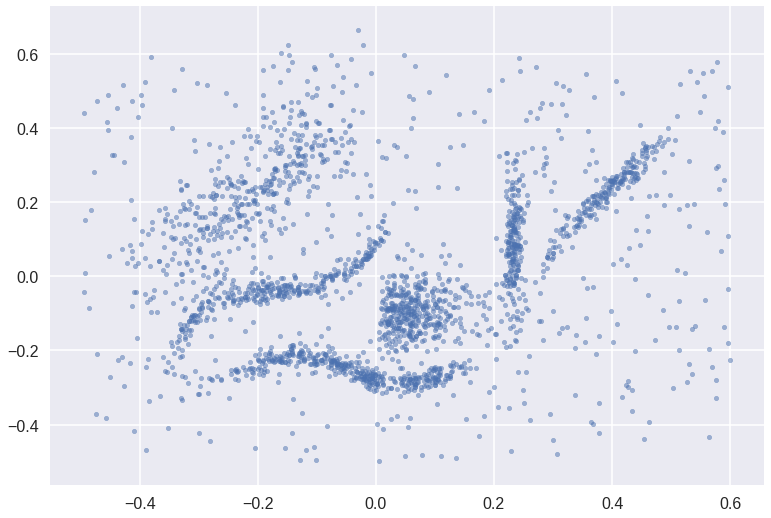

In [3]:
plt.scatter(x=data[:,0], y=data[:,1], alpha=0.5, s=20)

As you can see there are various clumps in the data that we would like to be able to extract. To do this we will make use of the HDBSCAN\* clustering algorithm, available in the python package ``hdbscan``. If ``hdbscan`` isn't already installed in your environemnt then you can get it via

    $ conda install hdbscan
    
We will now import ``hdbscan`` and use it to extract clusters from this data.

In [4]:
import hdbscan

The ``hdbscan`` library has a class ``HDBSCAN`` that does the work. This class works just like other estimators in scikit-learn, so if you are familiar with scikit-learn you already know how it works. If not then you can simply follow along. To start with we need to instantiate a clustering object.

In [5]:
clusterer = hdbscan.HDBSCAN()

Now we need to fir the clusterer to our data. We do that using the ``fit`` method.

In [6]:
clusterer.fit(data)

HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

The data is now clustered. To look at results you can start with the ``labels_`` attribute which was created when we fir the clusterer to the data.

In [7]:
clusterer.labels_

array([28, -1, 22, ..., -1, -1, -1])

We have an array of integers -- what does this mean? Each cluster is assigned a number, and then each observation is assigned a cluster label. Thus the labels array is an array with one entry per observation in our data set. In other words the first data point is in cluster number 28, and the third data point is in cluster 22. What about those -1 values? The HDBSCAN\* algorithm allows some data points to be classed as 'noise' that isn't in any cluster, and assigns those points the label -1.

We can plot the results to see what happened. We will plot the noise and clusters separately so that we can colour the noise gray and use colormaps to color the clusters. Note that because we have many clusters some of the colors selected will be very similar, but represent disjoint clusters.

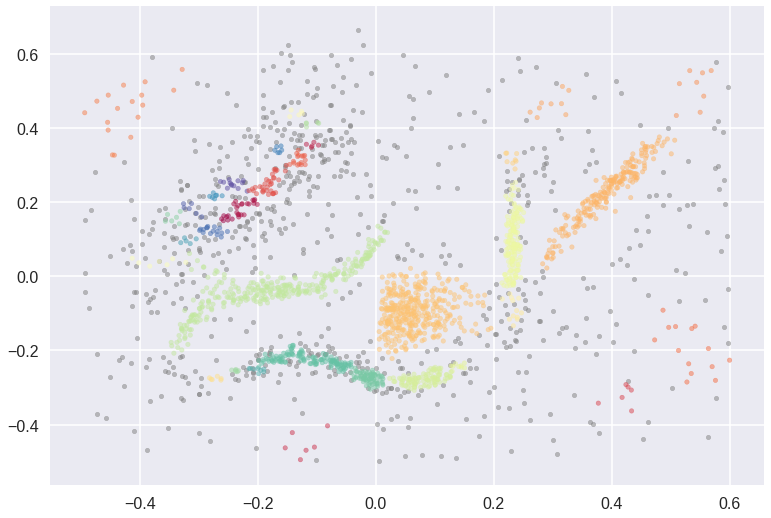

In [8]:
plt.scatter(x=data[clusterer.labels_ == -1,0], y=data[clusterer.labels_ == -1,1], c='gray', alpha=0.5, s=20)
plt.scatter(x=data[clusterer.labels_ >= 0,0], y=data[clusterer.labels_ >= 0,1], 
            c=clusterer.labels_[clusterer.labels_ >= 0], cmap='Spectral', alpha=0.5, s=20)

This is not a bad result, but not ideal either. In practice you may wish to make use of parameters -- while hdbscan tries to pick some sensible defaults, it is worth seeing how the data clusters under a few different choices. The main parameter to play with is the min_cluster_size; by setting it larger we make the clustering more conservative, selecting on larger less noisy clusters. We can try that now.

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15)
clusterer.fit(data)
clusterer.labels_

array([ 5,  5,  5, ..., -1, -1,  5])

Now we have fewer clusters, which we can check by asking for the maximum cluster id in the labels array.

In [10]:
clusterer.labels_.max()

5

We can again plot the clusters, using the same colormapping trick as before.

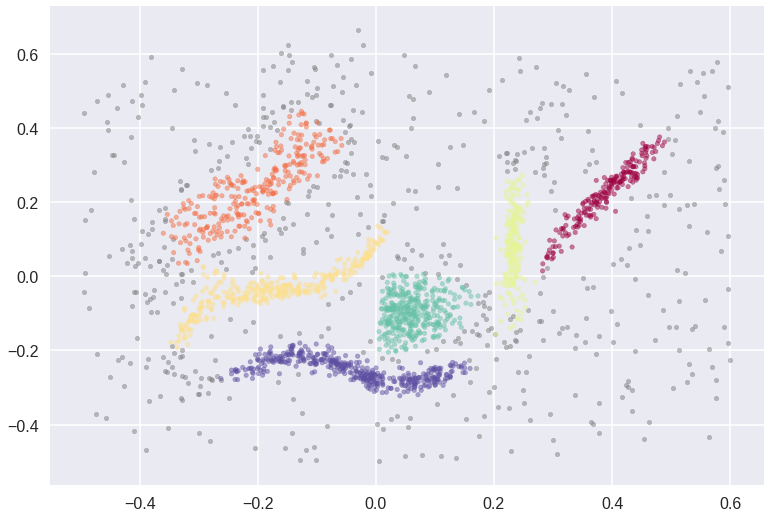

In [11]:
plt.scatter(x=data[clusterer.labels_ == -1,0], y=data[clusterer.labels_ == -1,1], c='gray', alpha=0.5, s=20)
plt.scatter(x=data[clusterer.labels_ >= 0,0], y=data[clusterer.labels_ >= 0,1], 
            c=clusterer.labels_[clusterer.labels_ >= 0], cmap='Spectral', alpha=0.5, s=20)

This time we have something more like what we were perhaps looking for; a smaller number of clear clusters.

Now in this example we could plot the data and check to see if we were getting clusters that made sense. That can be harder in general. What can we do when the data isn't conveniently two dimensional? You can use dimension reduction techniques such as t-SNE to try to visualise your data (see notebooks on t-SNE and data visualisation). Alternatively you can look through the data in each cluster and, using background knowledge attempt to determine if this is a sensible clustering. You can tweak parameters and see what different clusterings result to gain more intuition about how the cluster form.

Fortunately ``hdbscan`` comes with some other extra tools to help you explore the clusters that it found, and understand how they fit into the bigger picture. The first of these is the condensed tree, which is a hierarchy of clusters from which the flat clustering we looked at so far was extracted. The ``hdbscan`` library allows access to the condensed tree via the ``condensed_tree_`` attribute, and even has a convenient ``plot`` method to visualise the tree.

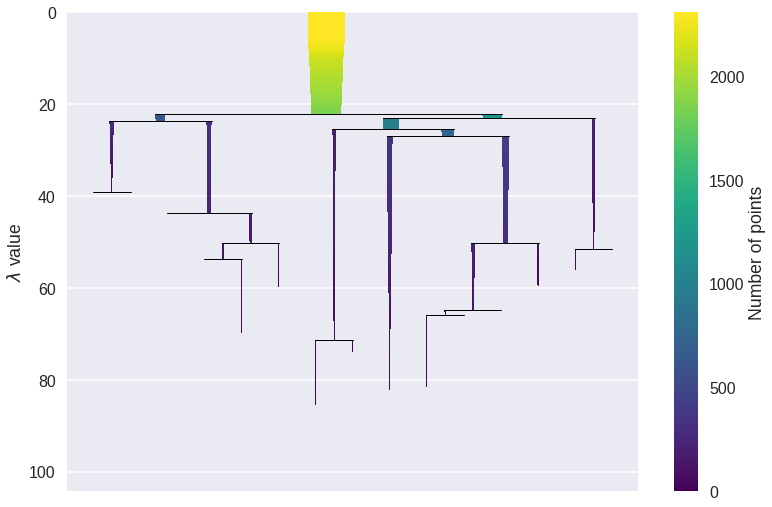

In [12]:
clusterer.condensed_tree_.plot()

Here we can see the hierarchy of clusters. The thicker the branch the more points in the cluster, starting from the root of the tree at the top which initially contains all the observations. We can ask the tree to tell us which clusters were selected (among a host of other options to the plot method). If we plot the clusters with a fixed color palette we can pass that the the condensed tree plotting allowing us to identify clusters in the tree and scatter plot.

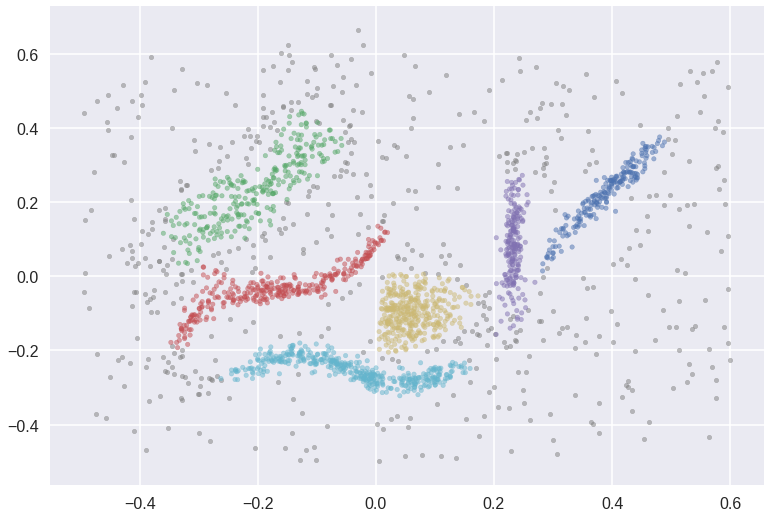

In [13]:
palette = sns.color_palette('deep', 6)
plt.scatter(x=data[clusterer.labels_ == -1,0], y=data[clusterer.labels_ == -1,1], c='gray', alpha=0.5, s=20)
color_mapping = [palette[x] for x in clusterer.labels_[clusterer.labels_ >= 0]]
plt.scatter(x=data[clusterer.labels_ >= 0,0], y=data[clusterer.labels_ >= 0,1], 
            c=color_mapping, alpha=0.5, s=20)

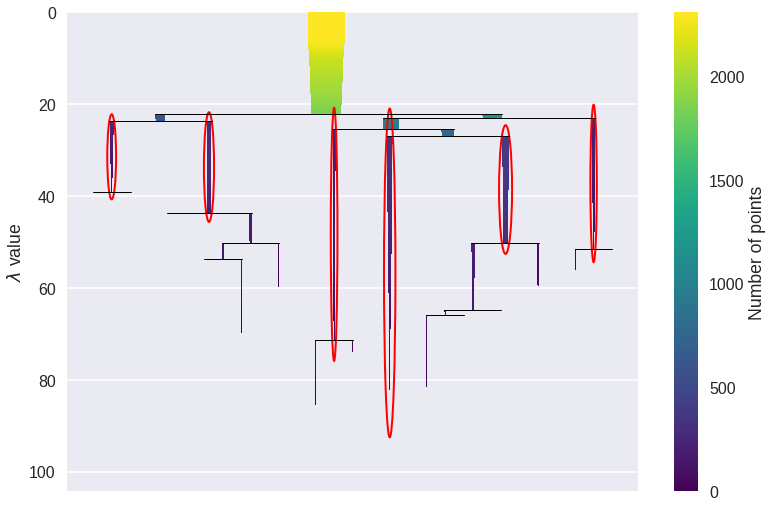

In [14]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=palette)

This allows us to see, for example that the green cluster breaks apart quite quickly (having a very short vertical span) which the yellow and purple clusters are very strongly tied together. Also notable is that the red and cyan clusters rapidly split in two, with each half persisting for some time. We can also see that the red and green clusters are closer to one another than the remaining clusters, and that the yellow and cyan clusters are the last cluster to split apart, having persisted together for a while.

If we just want to understand the absolute persistence of cluster -- how conherent are they -- we can look at the ``cluster_persistence`` scores. The larger the score the more coherent a cluster. I will plot colors in the same order as the scores below so you cna match scores to the visual clusters in the plot above.

In [15]:
clusterer.cluster_persistence_

array([ 0.21893296,  0.09298002,  0.17251334,  0.30865847,  0.30943422,
        0.2086923 ])

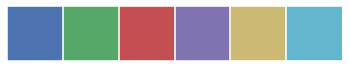

In [16]:
sns.palplot(palette)

Here we can see that, according to these scores the green cluster (the second score) is the weakest; which matches our intuition looking at the plot. Similarly the scores tell us the yellow and purple clusters are the most coherent.

Hopefully this provides an introduction to cluster analysis using ``hdbscan``. Please feel free to contact the data science learning team if you would like to know more, or need some help with your clustering problems.